# Lane detection
## Single image lane detection
By Xinyi Yang, Tao Jia, Zhiling Huang

Steps:
1. Crop image
2. Grayscale, Sobel, Black-and-white binarization
3. Hough line transformation
4. Regress to get straint lines
5. Compare prediction and true labels
6. Calculate accuracy


In [1]:
import math
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [15]:
def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)

    
def select_region(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0, rows*1.0]
    top_left     = [cols*0, rows*0.3]
    bottom_right = [cols*1.0, rows*1.0]
    top_right    = [cols*1.0, rows*0.3] 
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)

In [16]:
# in order to get stable lane, buffer N frames' slopes and intercepts
pre_l_slopes = []
pre_l_inters = []  
pre_r_slopes = []
pre_r_inters = []


def clear_buffer():
    """
    rest the lines buffer
    :return:
    """
    pre_l_slopes.clear()
    pre_l_inters.clear()
    pre_r_slopes.clear()
    pre_r_inters.clear()

def selectWhiteAndYellow(img):
    """
    selec the white and yellow component in the hsv space.
    (1) set the yellow/white lower and upper bound
    (2) apply the mask to the hsv space image
    """
    lower_yellow = np.array([65, 100, 100], np.uint8)
    upper_yellow = np.array([105, 255, 255], np.uint8)
    yellow_mask = cv2.inRange(img, lower_yellow, upper_yellow)

    lower_white = np.array([0, 0, 200])
    upper_white = np.array([179, 20, 255])  # range for H is 0:179
    white_mask = cv2.inRange(img, lower_white, upper_white)

    img = cv2.bitwise_and(img, img, mask=cv2.bitwise_or(yellow_mask, white_mask))
    return img

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [17]:
# Input: image and parameters
# Output: list of list that contains the start points (x1, y1) and end points (x2, y2)
# of hough lines (line interval)
# Use hough line transformation
def find_slopes(img, minLineLength, maxLineGap):
    lines = cv2.HoughLinesP(img,1,np.pi/180,100, minLineLength, maxLineGap)
    THRES_ANGLE = 10  # if the line angle is between -10 to 10 degrees, lines are discarded
    THRES_SLOPE = math.tan(THRES_ANGLE / 180 * math.pi)
    slopes = []
    intercepts = []
    line_cols = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x2 != x1:
                slope = float(y2 - y1) / float(x2 - x1)
                if abs(slope) > THRES_SLOPE:
                    slopes.append(slope)
                    inter = y1 - slope * x1
                    intercepts.append(inter)
                    line_cols.append((slope, inter, x1, y1, x2, y2))
    return line_cols

In [55]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
"""
Clustering hough lines
use Silhouette score to find the optimal number of lanes
Output:
num_cluster
final_labels: centers of clusters
clusters: dictionary. key = cluster label, value = lines that belong to this cluster
"""
def find_num_lanes(line_cols):
    # line_cols = (slope, inter, x1, y1, x2, y2)
    MAX_CLUSTER = 5
    MIN_CLUSTER = 2
    line_cols.sort(key=lambda tup: tup[0])
    cluster_slope = 1
    cluster_slope_start = []
    cluster_slope_start.append(0)
    cluster_slope_end = []
    for i in range(len(line_cols)-1):
        if line_cols[i+1][0] - line_cols[i][0] > 0.2:
            cluster_slope +=1
            cluster_slope_end.append(i)
            cluster_slope_start.append(i+1)
    cluster_slope_end.append(n-1)
    # remove clusters where there is only one line (possibly outliers)
    abnormal = []
    to_delete =[]
    for i in range(len(cluster_slope_start)):
        if cluster_slope_end[i] - cluster_slope_start[i] == 0:
            abnormal.append(cluster_slope_end[i])
    print ('total num of lines: ', len(line_cols))
    if len(abnormal) > 0:
        for i in abnormal:
            print ('abnormal:', i)
            to_delete.append(i)
        line_cols = [line_cols[i] for i in range(len(line_cols)) if i not in to_delete]
        cluster_slope -= len(abnormal)
    # constrin the number of clusters between 2 and 5
    num_cluster = max(min(MAX_CLUSTER, cluster_slope), MIN_CLUSTER)
    """
    #x_list = []
    #midpoint = []
    #x_list.append(x1)
    #x_list.append(x2)
    #x1, y1, x2, y2 = zip(*line_cols)
    #x_mid = [(a + b)/2 for a, b in zip(x1, x2)]
    #y_mid = [(a + b)/2 for a, b in zip(y1, y2)]
    #X = np.column_stack((x_mid, y_mid))
    #num_lane_candidate = []
    #for X in x_list:
    slopes = sorted(slopes)
    slopes = np.asarray(slopes)
    candidate = {}
    X = slopes.reshape(-1, 1)
    for n_clusters in CLUSTER_RANGE:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init=50).fit(X)
        cluster_labels = clusterer.predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels, metric='euclidean')
        candidate[n_clusters] = silhouette_avg
    print (candidate)
    temp = max(candidate, key=candidate.get)
    print (temp)
    #num_lane_candidate.append(temp)
    num_lane = temp
    
    x1 = np.asarray(slopes)
    x2 = np.asarray(intercepts)
    X = np.column_stack((x1, x2))
    """
    slope_list = [i[0] for i in line_cols]
    X = np.asarray(slope_list)
    X = X.reshape(-1, 1)
    estimator = KMeans(n_clusters=num_cluster).fit(X)
    final_labels = estimator.cluster_centers_
    clusters = {i: np.where(estimator.labels_ == i)[0] for i in range(estimator.n_clusters)}
    return num_cluster, final_labels, clusters

In [19]:
def outlierCleaner(predictions, x, y, inlier_percent=0.9):
    """
        Clean away the 10% of points that have the largest
        residual errors (difference between the prediction
        and the actual y values).

        Return a list of tuples named cleaned_data where
        each tuple is of the form (x, y, error).
    """
    threshold = 10  # if the biggest error is greater than 5 pixels, we perform outliers remove
    errs = np.fabs(y - predictions)
    max_err = max(errs)[0]
    if max_err > threshold:  # if the biggest error is greater than 5 pixels, we remove the outliers
        k = math.ceil(errs.size * inlier_percent)
        survived_idx = np.argsort(errs, axis=0)[:k]  # find the number of k min errs, and return their index
        if survived_idx.size > 0:
            x = np.take(x, survived_idx)
            y = np.take(y, survived_idx)

    return (x, y)

In [20]:
def findTwoPoints(slope, inter):
    """
    In order to get two stable lanes,

    :param slope: current slope from the regressor for current frame
    :param inter: current intercept from the regressor for current frame
    :return tow points locations, which are the two ends of a lane
    """
    
    # fix the y coordinates of the top and bottom points
    top_y = 250
    bottom_y = 719

    p1_y = bottom_y
    p1_x = int((float(p1_y)-inter)/slope)
    p2_y = top_y
    p2_x = int((float(p2_y)-inter)/slope)

    return (p1_x, p1_y, p2_x, p2_y)

In [69]:
def regress_a_lane(img, line_cols, clusters, outputrange, color=[255, 0, 0], thickness=10):
    """ regress a line from a cluster of points and add it to img
    (1) use a linear regressor to fit the data (x,y)
    (2) remove outlier, and then fit the cleaned data again to get slope and intercept
    (3) find the two ends of the desired line by using slope and intercept
    
    :param img: input image
    :param line_cols: hough line transformation output
    :param clusters: clustering hough lines into 2-5 groups (indicating 2-5 lines)
    :param color: line color
    :param thickness: thickness of the line  
    """
    # find the two end points of the line by using slope and iter, and then visulize the line
    
    lr = LinearRegression()
    height = img.shape[0]
    lane_pred = []
    if len(clusters) == 0:
        return img
    if len(clusters) == 1:
        ind = clusters[0]
        x1_list = []
        x2_list = []
        y1_list = []
        y2_list = []
        for j in ind:
            sl, inter, x1, y1, x2, y2 = line_cols[j]
            x1_list.append(x1)
            y1_list.append(y1)
            x2_list.append(x2)
            y2_list.append(y2)
        x = x1_list + x2_list
        y = y1_list + y2_list
        x = np.asarray(x)
        y = np.asarray(y)
        x = x.reshape(-1, 1)
        y = y.reshape(-1, 1)
        lr.fit(x, y)
        slope = lr.coef_
        intercept = lr.intercept_
        p1_x, p1_y, p2_x, p2_y = findTwoPoints(slope, intercept)
        cv2.line(img, (p1_x, p1_y), (p2_x, p2_y), color, thickness)
        x_labels = [int((float(p_y)-inter)/slope) for p_y in outputrange]
        
    else:
        for i in range(len(clusters)):
            ind = clusters[i]
            x1_list = []
            x2_list = []
            y1_list = []
            y2_list = []
            for j in ind:
                sl, inter, x1, y1, x2, y2 = line_cols[j]
                x1_list.append(x1)
                y1_list.append(y1)
                x2_list.append(x2)
                y2_list.append(y2)
            x = x1_list + x2_list
            y = y1_list + y2_list
            x = np.asarray(x)
            y = np.asarray(y)
            x = x.reshape(-1, 1)
            y = y.reshape(-1, 1)
            lr.fit(x, y)
            slope = lr.coef_
            intercept = lr.intercept_
            p1_x, p1_y, p2_x, p2_y = findTwoPoints(slope, intercept)
            cv2.line(img, (p1_x, p1_y), (p2_x, p2_y), color, thickness)
            for p_y in outputrange:
                p_x = int((float(p_y)-inter)/slope) 
                if p_x > 1280 or p_x < 1:
                    p_x = -2
                onepoint = []
                onepoint.append(i+1)
                onepoint.append(p_x)
                onepoint.append(p_y)
                lane_pred.append(onepoint)
            
    return img, lane_pred
    
"""
    # identify and remove outliers
    cleaned_data = []
    try:
        predictions = reg.predict(x)
        cleaned_data = outlierCleaner(predictions, x, y)
    except NameError:
        print("err in regression prediction")

    if len(cleaned_data) > 0:
        x, y = cleaned_data   
        # refit cleaned data!
        try:
            reg.fit(x, y)
        except NameError:
            print("err in reg.fit for cleaned data")
    else:
        print("outlierCleaner() is returning an empty list, no refitting to be done")
"""

'\n    # identify and remove outliers\n    cleaned_data = []\n    try:\n        predictions = reg.predict(x)\n        cleaned_data = outlierCleaner(predictions, x, y)\n    except NameError:\n        print("err in regression prediction")\n\n    if len(cleaned_data) > 0:\n        x, y = cleaned_data   \n        # refit cleaned data!\n        try:\n            reg.fit(x, y)\n        except NameError:\n            print("err in reg.fit for cleaned data")\n    else:\n        print("outlierCleaner() is returning an empty list, no refitting to be done")\n'

Text(0.5,1,'Hough Lines + Sobel Edge detection')

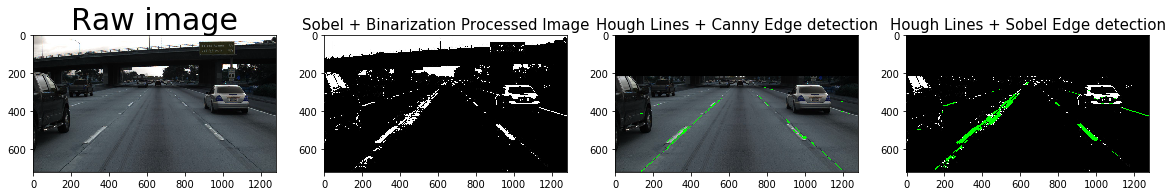

In [45]:
# Single image preprocessing -> output hough lines

minLineLength = 150
maxLineGap = 10

filename_bw = 'benchmark/BW_v3/20.jpg'
filename_color = 'benchmark/20.jpg'

raw = cv2.imread(filename_color)
raw_bw = cv2.imread(filename_bw)
img = cv2.imread(filename_bw)
img_col = cv2.imread(filename_color)

img = select_region(img)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
lines = cv2.HoughLinesP(gray,1,np.pi/180,100,minLineLength,maxLineGap)

img_col = select_region(img_col)
gray_col = cv2.cvtColor(img_col,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray_col,20,150,apertureSize = 3)
lines_col = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)

n = 0
THRES_ANGLE = 10  # if the line angle is between -5 to 5 degrees, lines are discarded
THRES_SLOPE = math.tan(THRES_ANGLE / 180 * math.pi)
for line in lines:
    for x1,y1,x2,y2 in line:
        if x2 != x1:
            slope = float(y2 - y1) / float(x2 - x1)
            if abs(slope) > THRES_SLOPE:
                cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
                n += 1

for line in lines_col:
    for x1,y1,x2,y2 in line:
        if x2 != x1:
            slope = float(y2 - y1) / float(x2 - x1)
            if abs(slope) > THRES_SLOPE:
                cv2.line(img_col,(x1,y1),(x2,y2),(0,255,0),2)
                
#cv2.imwrite('test_temp.jpg',img)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
ax1.imshow(raw, cmap="gray")
ax1.set_title('Raw image', fontsize=30)
ax2.imshow(raw_bw, cmap="gray")
ax2.set_title('Sobel + Binarization Processed Image', fontsize=15)
ax3.imshow(img_col)
ax3.set_title('Hough Lines + Canny Edge detection', fontsize=15)
ax4.imshow(img)
ax4.set_title('Hough Lines + Sobel Edge detection', fontsize=15)


total num of lines:  35
[[1, 729, 160], [1, 718, 170], [1, 706, 180], [1, 695, 190], [1, 684, 200], [1, 672, 210], [1, 661, 220], [1, 649, 230], [1, 638, 240], [1, 627, 250], [1, 615, 260], [1, 604, 270], [1, 593, 280], [1, 581, 290], [1, 570, 300], [1, 559, 310], [1, 547, 320], [1, 536, 330], [1, 525, 340], [1, 513, 350], [1, 502, 360], [1, 491, 370], [1, 479, 380], [1, 468, 390], [1, 457, 400], [1, 445, 410], [1, 434, 420], [1, 423, 430], [1, 411, 440], [1, 400, 450], [1, 389, 460], [1, 377, 470], [1, 366, 480], [1, 355, 490], [1, 343, 500], [1, 332, 510], [1, 321, 520], [1, 309, 530], [1, 298, 540], [1, 287, 550], [1, 275, 560], [1, 264, 570], [1, 253, 580], [1, 241, 590], [1, 230, 600], [1, 219, 610], [1, 207, 620], [1, 196, 630], [1, 185, 640], [1, 173, 650], [1, 162, 660], [1, 151, 670], [1, 139, 680], [1, 128, 690], [1, 117, 700], [1, 105, 710], [2, 542, 160], [2, 575, 170], [2, 608, 180], [2, 642, 190], [2, 675, 200], [2, 708, 210], [2, 742, 220], [2, 775, 230], [2, 809, 240], 

Text(0.5,1,'Correct Lanes')

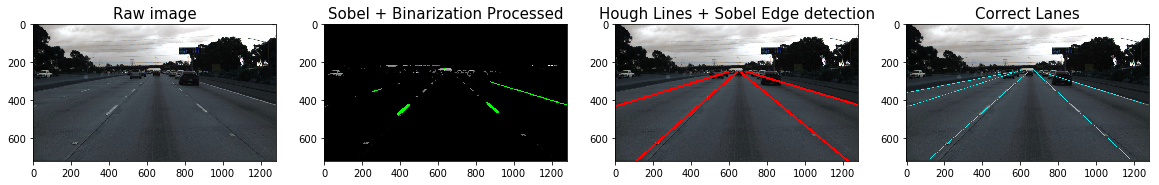

In [115]:
import cv2
import numpy as np
minLineLength = 150
maxLineGap = 30

filename = 'benchmark0/color/20.jpg'

sobel_raw = cv2.imread(filename)
sobel_display = cv2.imread(filename)
sobel = cv2.imread('benchmark0/BW/BW_20.jpg')

sobel = select_region(sobel)
sobel_final = cv2.cvtColor(sobel,cv2.COLOR_BGR2GRAY)
sobel_lines = cv2.HoughLinesP(sobel_final,1,np.pi/180,100,minLineLength,maxLineGap)

THRES_ANGLE = 10  # if the line angle is between -5 to 5 degrees, lines are discarded
THRES_SLOPE = math.tan(THRES_ANGLE / 180 * math.pi)
for line in sobel_lines:
    for x1,y1,x2,y2 in line:
        if x2 != x1:
            slope = float(y2 - y1) / float(x2 - x1)
            if abs(slope) > THRES_SLOPE:
                cv2.line(sobel,(x1,y1),(x2,y2),(0,255,0),2)

line_cols = find_slopes(sobel_final, minLineLength, maxLineGap)
num_lane, final_labels, clusters = find_num_lanes(line_cols)

outputrange = range(160, 720, 10)
output_img, lane_pred = regress_a_lane(sobel_display, line_cols, clusters, outputrange)

print (lane_pred)

# Draw labels for comparison
correct = cv2.imread(filename)
lane = [[(569, 250), (3, 360)], [(615, 240), (19, 430)], [(644, 250), (123, 710)], [(670, 240),(1183, 710)],
       [(711, 250), (1260, 420)]]
for i in range(len(lane)):
    cv2.line(correct,lane[i][0],lane[i][1],(0,255,255),2)


f, (ax1, ax2,  ax4, ax5) = plt.subplots(1, 4, figsize=(20,10))
ax1.imshow(sobel_raw)
ax1.set_title('Raw image', fontsize=15)
ax2.imshow(sobel)
ax2.set_title('Sobel + Binarization Processed', fontsize=15)
ax4.imshow(output_img)
ax4.set_title('Hough Lines + Sobel Edge detection', fontsize=15)
ax5.imshow(correct)
ax5.set_title('Correct Lanes', fontsize=15)

total num of lines:  84
abnormal: 48
total num of lines:  39
abnormal: 11
total num of lines:  50
abnormal: 2
abnormal: 27
total num of lines:  60
abnormal: 0
abnormal: 37
total num of lines:  13
total num of lines:  54
abnormal: 0
abnormal: 1
abnormal: 2
abnormal: 3
abnormal: 4
abnormal: 5
abnormal: 6
abnormal: 7
abnormal: 8
abnormal: 17
total num of lines:  47
abnormal: 0
abnormal: 1
abnormal: 2
abnormal: 5
abnormal: 6
abnormal: 7
total num of lines:  57
abnormal: 0
abnormal: 1
abnormal: 4
abnormal: 9
abnormal: 10
abnormal: 11
abnormal: 16
abnormal: 32
total num of lines:  0


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

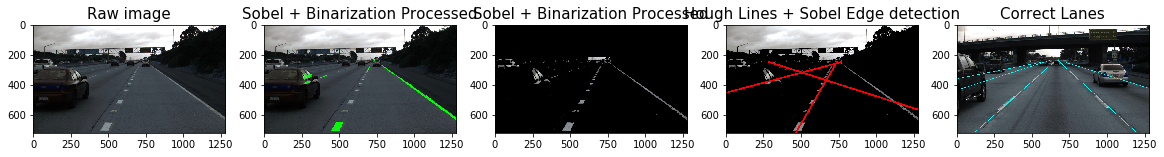

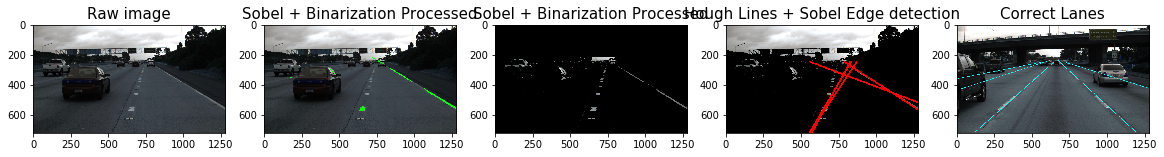

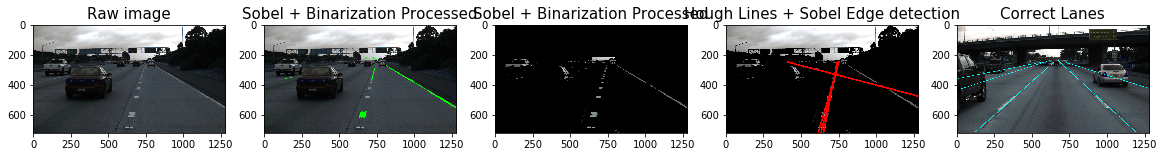

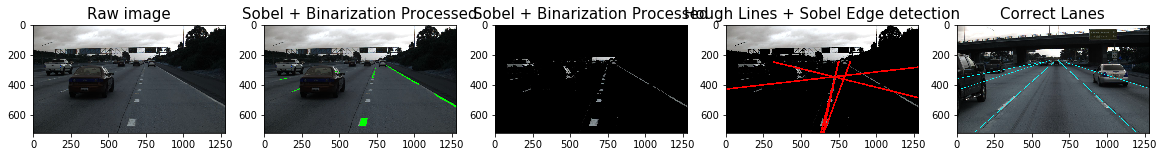

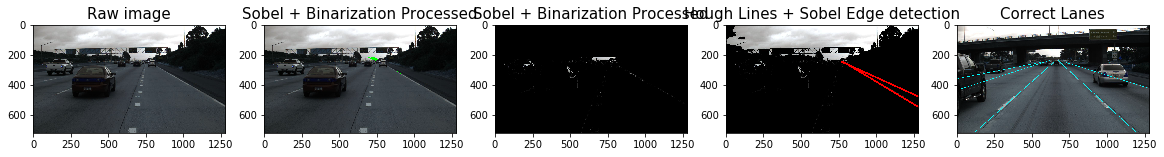

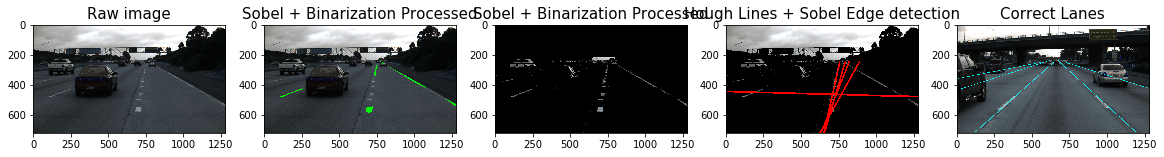

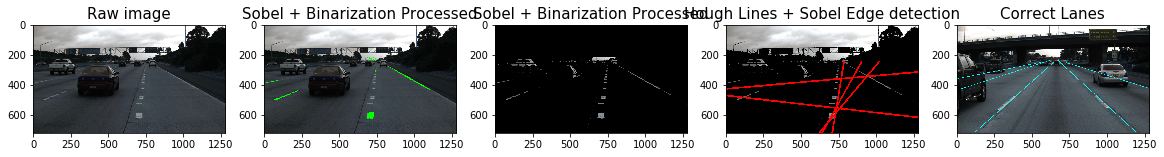

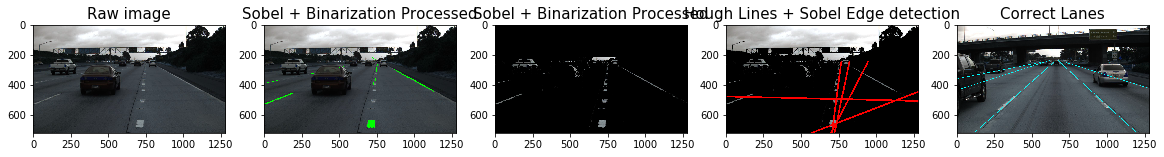

In [71]:
minLineLength = 150
maxLineGap = 30
for fn in os.listdir('benchmark3/color/'):
    fileName, ending = os.path.splitext(fn)
    if ending != ".jpg":
        continue
    sobel_bw = cv2.imread('benchmark3/BW/' +'BW_' + fileName + ending)
    sobel_display = cv2.imread('benchmark3/BW/' + 'BW_'  + fileName + ending)
    sobel = cv2.imread('benchmark3/color/' + fileName + ending)
    sobel_raw = cv2.imread('benchmark3/color/' + fileName + ending)

    sobel_cut = select_region(sobel_bw)
    sobel_gray = cv2.cvtColor(sobel_cut,cv2.COLOR_BGR2GRAY)
    sobel_lines = cv2.HoughLinesP(sobel_gray,1,np.pi/180,100,minLineLength,maxLineGap)

    THRES_ANGLE = 10  # if the line angle is between -5 to 5 degrees, lines are discarded
    THRES_SLOPE = math.tan(THRES_ANGLE / 180 * math.pi)
    for line in sobel_lines:
        for x1,y1,x2,y2 in line:
            if x2 != x1:
                slope = float(y2 - y1) / float(x2 - x1)
                if abs(slope) > THRES_SLOPE:
                    cv2.line(sobel,(x1,y1),(x2,y2),(0,255,0),2)

    line_cols = find_slopes(sobel_gray, minLineLength, maxLineGap)
    num_lane, final_labels, clusters = find_num_lanes(line_cols)

    outputrange = range(160, 720, 10)
    output_img, lane_pred = regress_a_lane(sobel_display, line_cols, clusters, outputrange)


    # Draw labels for comparison
    correct = cv2.imread(filename)
    lane = [[(569, 250), (3, 360)], [(615, 240), (19, 430)], [(644, 250), (123, 710)], [(670, 240),(1183, 710)],
           [(711, 250), (1260, 420)]]
    for i in range(len(lane)):
        cv2.line(correct,lane[i][0],lane[i][1],(0,255,255),2)

    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,10))
    ax1.imshow(sobel_raw, cmap="gray")
    ax1.set_title('Raw image', fontsize=15)
    ax2.imshow(sobel, cmap="gray")
    ax2.set_title('Sobel + Binarization Processed', fontsize=15)
    ax3.imshow(sobel_cut, cmap="gray")
    ax3.set_title('Sobel + Binarization Processed', fontsize=15)
    ax4.imshow(output_img)
    ax4.set_title('Hough Lines + Sobel Edge detection', fontsize=15)
    ax5.imshow(correct)
    ax5.set_title('Correct Lanes', fontsize=15)

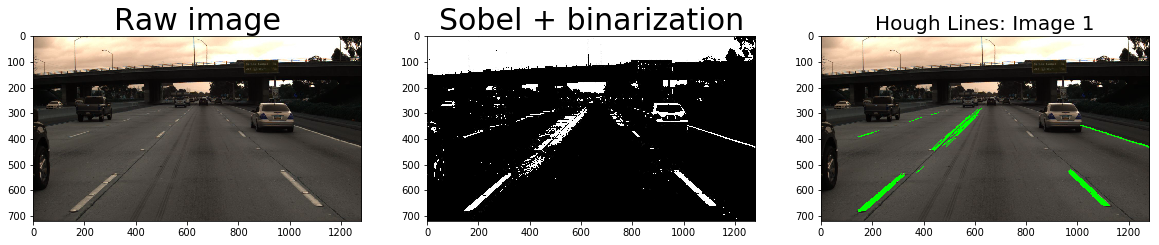

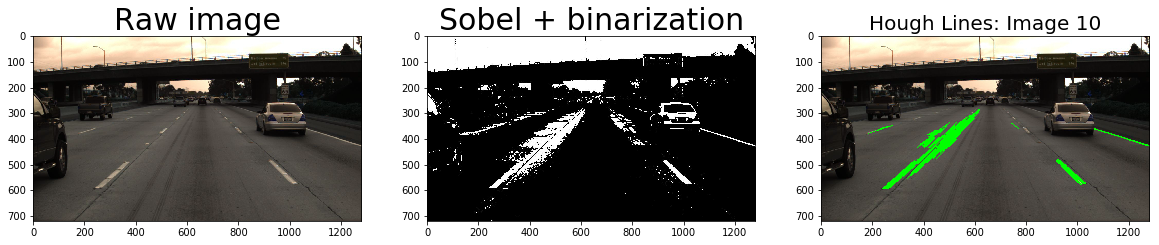

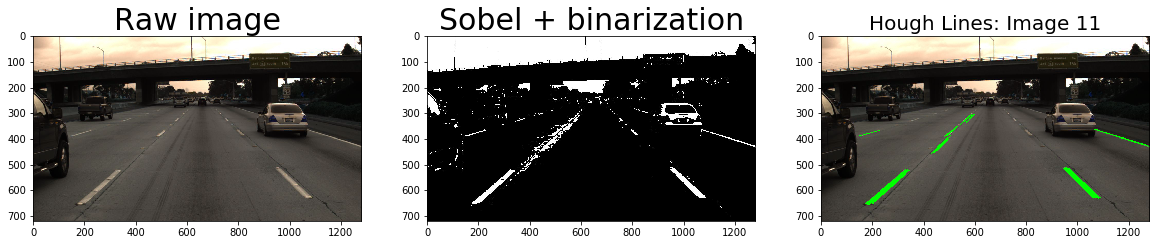

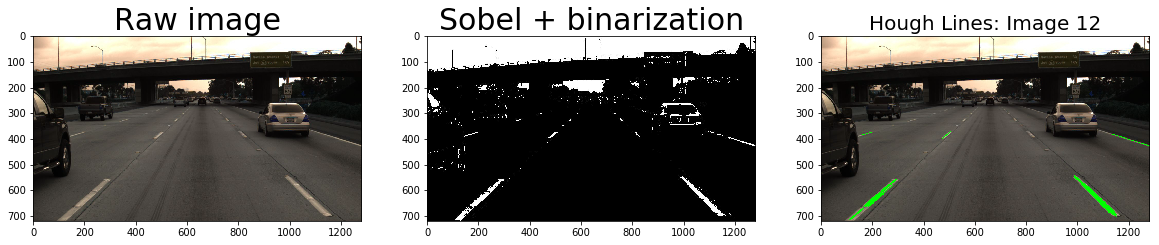

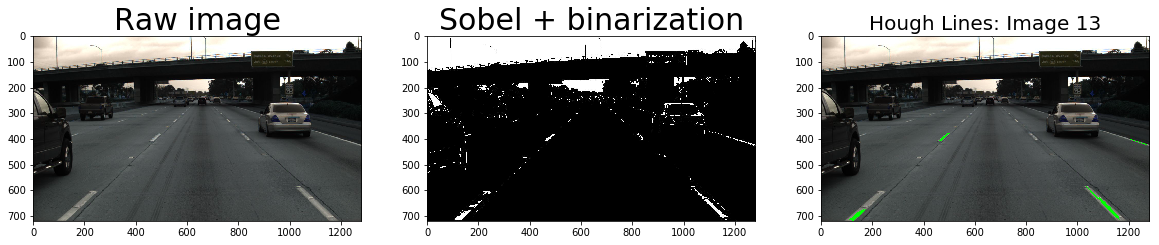

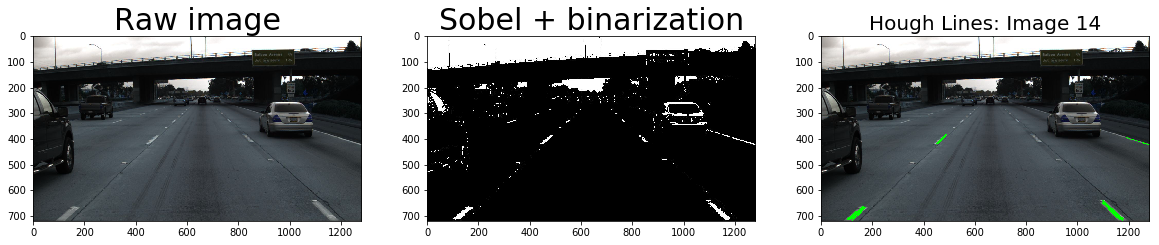

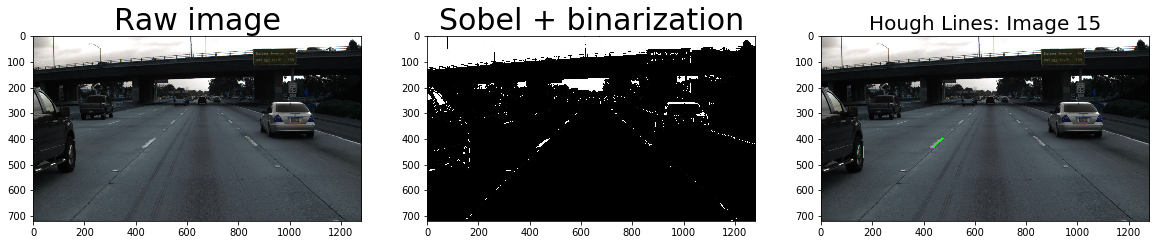

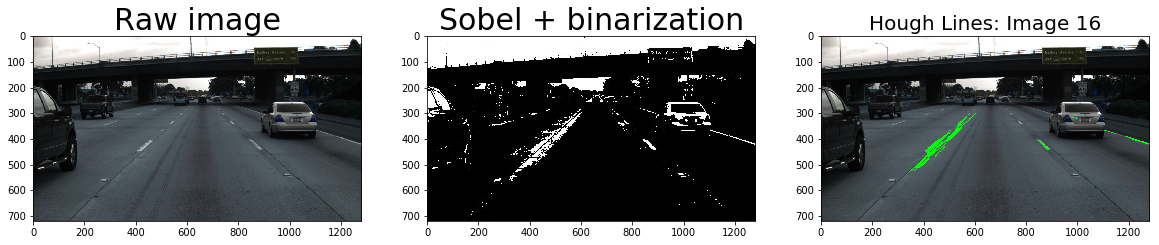

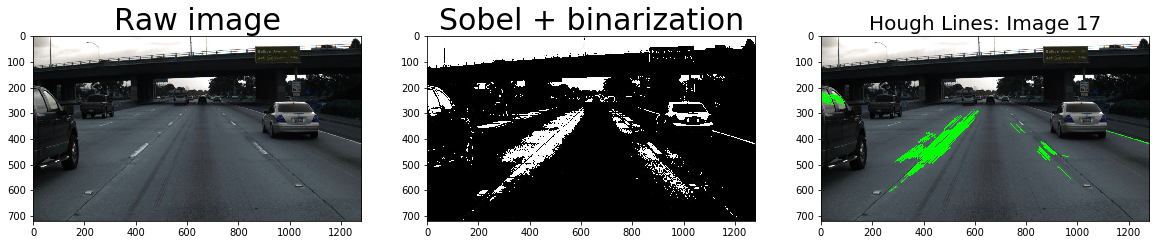

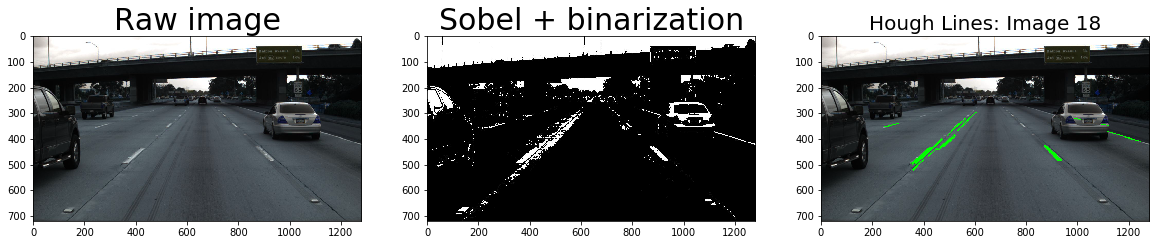

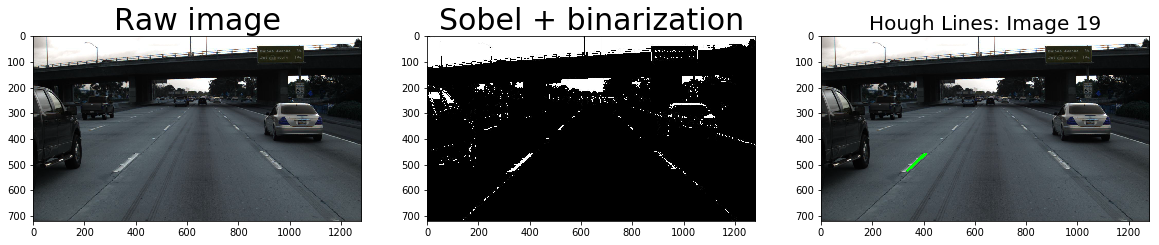

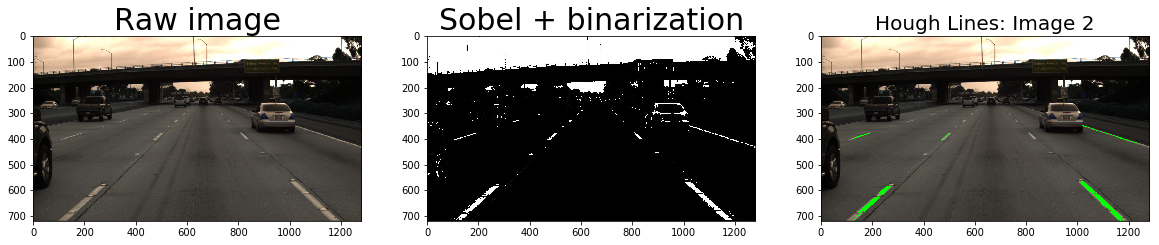

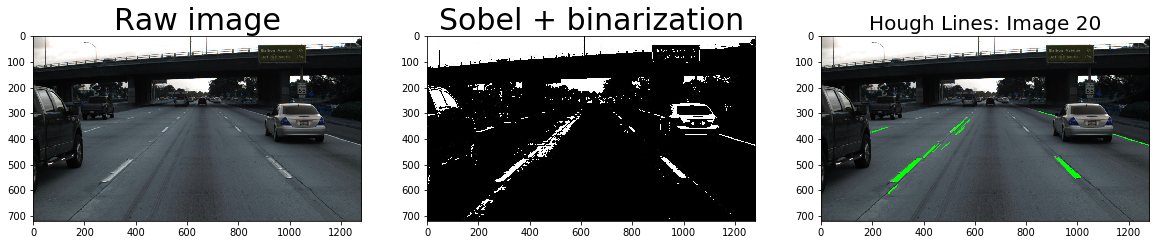

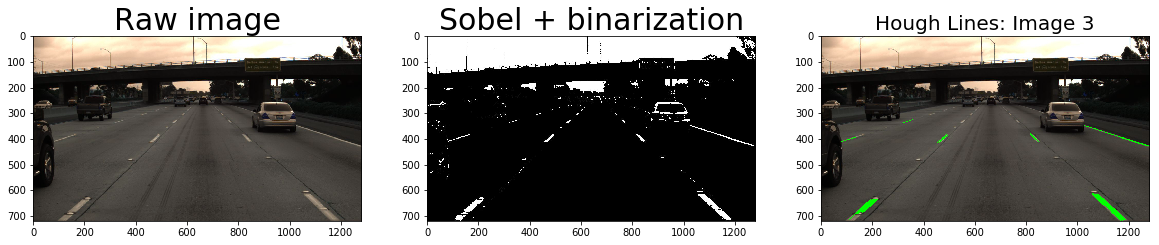

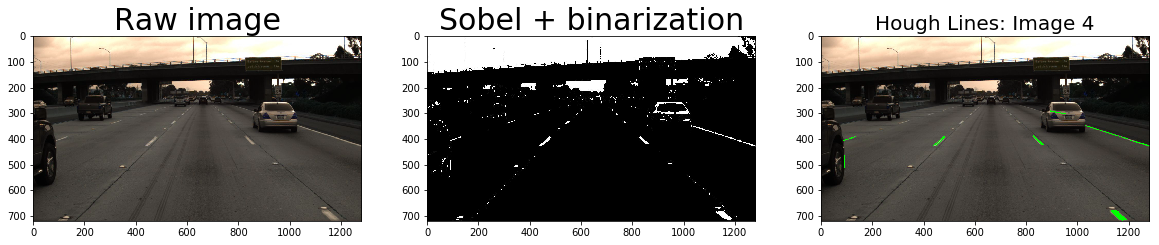

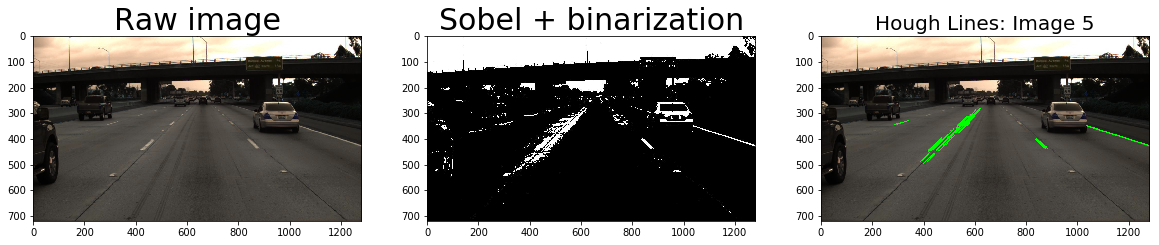

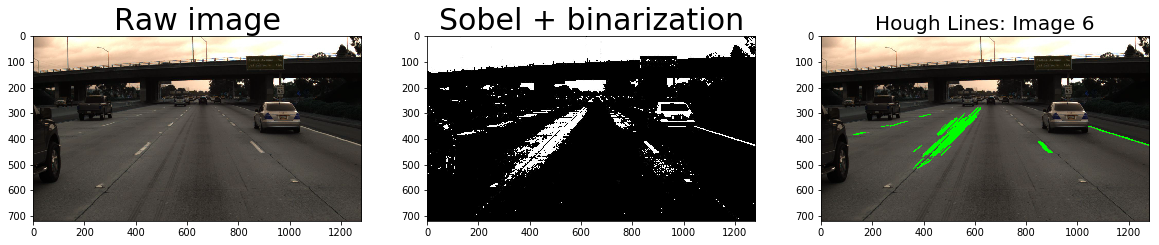

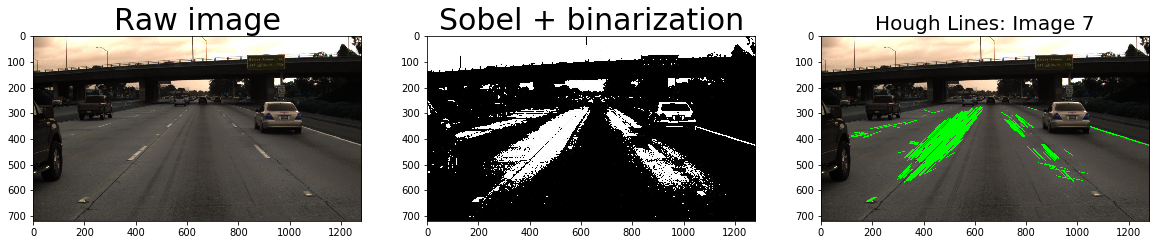

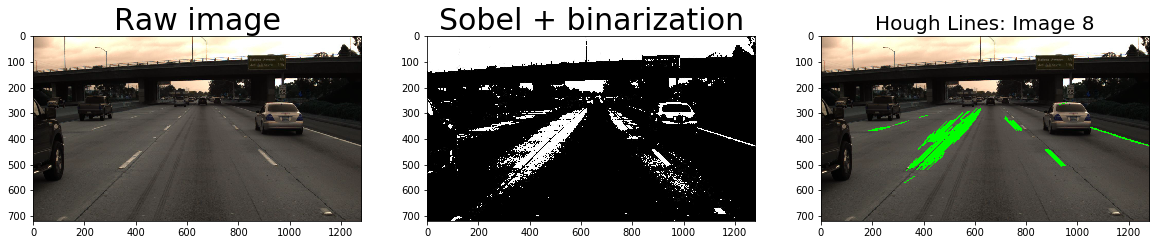

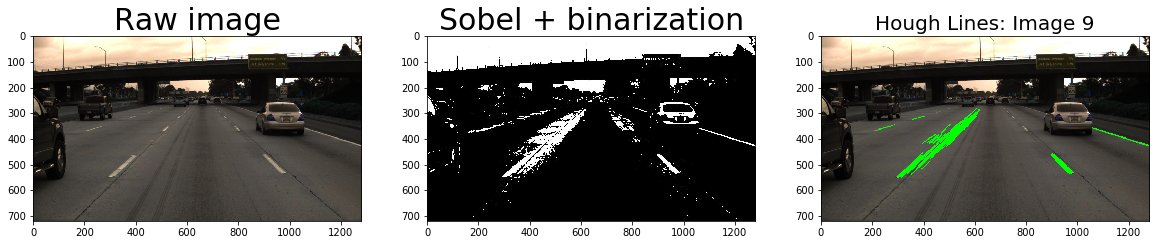

In [202]:
# Work on whole folder
minLineLength = 150
maxLineGap = 30
for fn in os.listdir('benchmark/BW_v3/'):
    fileName, ending = os.path.splitext(fn)
    if ending != ".jpg":
        continue
    img = cv2.imread('benchmark/BW_v3/' + fileName + ending)
    raw = cv2.imread('benchmark/' + fileName + ending)
    display = cv2.imread('benchmark/' + fileName + ending)
    sobel = select_region(img)
    sobel_final = cv2.cvtColor(sobel,cv2.COLOR_BGR2GRAY)
    sobel_lines = cv2.HoughLinesP(sobel_final,1,np.pi/180,100,minLineLength,maxLineGap)
    THRES_ANGLE = 10  # if the line angle is between -5 to 5 degrees, lines are discarded
    THRES_SLOPE = math.tan(THRES_ANGLE / 180 * math.pi)
    for line in sobel_lines:
        for x1,y1,x2,y2 in line:
            if x2 != x1:
                slope = float(y2 - y1) / float(x2 - x1)
                if abs(slope) > THRES_SLOPE:
                    cv2.line(display,(x1,y1),(x2,y2),(0,255,0),2)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.imshow(raw, cmap="gray")
    ax1.set_title('Raw image', fontsize=30)
    ax2.imshow(img, cmap="gray")
    ax2.set_title('Sobel + binarization', fontsize=30)
    ax3.imshow(display)
    ax3.set_title('Hough Lines: Image '+ fileName, fontsize=20)

Text(0.5,1,'Correct')

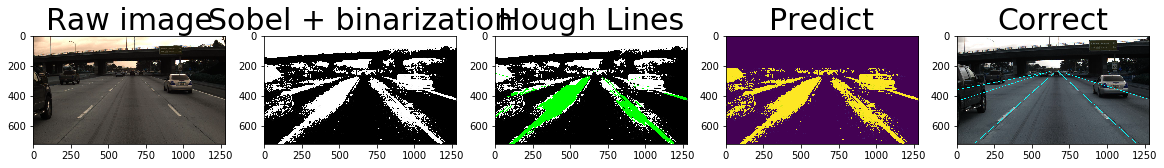

In [199]:
img = cv2.imread('benchmark/BW_overlap.jpg')
display = cv2.imread('benchmark/BW_overlap.jpg')
sobel = select_region(img)
sobel_bg = cv2.imread('benchmark/20.jpg')
sobel_final = cv2.cvtColor(sobel,cv2.COLOR_BGR2GRAY)
sobel_lines = cv2.HoughLinesP(sobel_final,1,np.pi/180,100,minLineLength,maxLineGap)
THRES_ANGLE = 10  # if the line angle is between -5 to 5 degrees, lines are discarded
THRES_SLOPE = math.tan(THRES_ANGLE / 180 * math.pi)
for line in sobel_lines:
    for x1,y1,x2,y2 in line:
        if x2 != x1:
            slope = float(y2 - y1) / float(x2 - x1)
            if abs(slope) > THRES_SLOPE:
                cv2.line(display,(x1,y1),(x2,y2),(0,255,0),2)

line_cols = find_slopes(sobel_final, minLineLength, maxLineGap)
num_lane, final_labels, clusters = find_num_lanes(line_cols)

outputrange = range(160, 730, 10)
output_img, lane_pred = regress_a_lane(sobel_bg, line_cols, clusters, outputrange)


# Draw labels for comparison
correct = cv2.imread('benchmark/20.jpg')
lane = [[(569, 250), (3, 360)], [(615, 240), (19, 430)], [(644, 250), (123, 710)], [(670, 240),(1183, 710)],
       [(711, 250), (1260, 420)]]
for i in range(len(lane)):
    cv2.line(correct,lane[i][0],lane[i][1],(0,255,255),2)
                
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,10))
ax1.imshow(raw, cmap="gray")
ax1.set_title('Raw image', fontsize=30)
ax2.imshow(img, cmap="gray")
ax2.set_title('Sobel + binarization', fontsize=30)
ax3.imshow(display)
ax3.set_title('Hough Lines', fontsize=30)
ax4.imshow(sobel_final)
ax4.set_title('Predict', fontsize=30)
ax5.imshow(correct)
ax5.set_title('Correct', fontsize=30)

Text(0.5,1,'Latent 20')

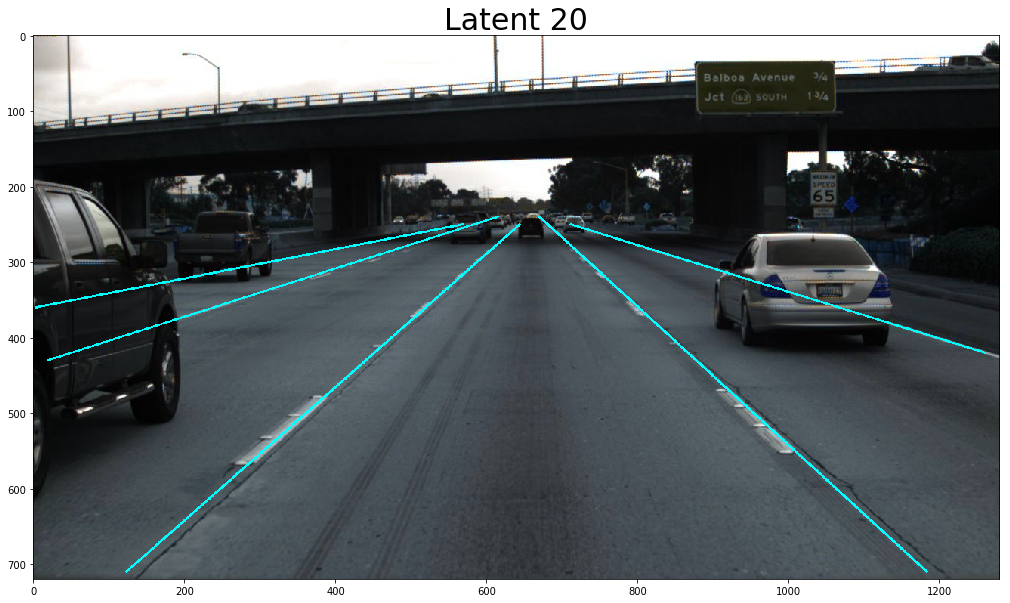

In [204]:
# Draw labels for comparison
correct = cv2.imread(filename)
lane = [[(569, 250), (3, 360)], [(615, 240), (19, 430)], [(644, 250), (123, 710)], [(670, 240),(1183, 710)],
       [(711, 250), (1260, 420)]]
for i in range(len(lane)):
    cv2.line(correct,lane[i][0],lane[i][1],(0,255,255),2)


f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.imshow(correct)
ax1.set_title('Latent 20', fontsize=30)

In [87]:
filename = 'benchmark0/label.txt'
def read_label(filename):
    labelfile = filename
    labels = []
    with open(labelfile) as f:
        for line in f:
            inner_list = [int(elt) for elt in line.split(' ')]
            labels.append(inner_list)
    return labels

[[1, -2, 160], [1, -2, 170], [1, -2, 180], [1, -2, 190], [1, -2, 200], [1, -2, 210], [1, -2, 220], [1, -2, 230], [1, -2, 240], [1, 569, 250], [1, 517, 260], [1, 466, 270], [1, 414, 280], [1, 363, 290], [1, 312, 300], [1, 260, 310], [1, 209, 320], [1, 157, 330], [1, 106, 340], [1, 54, 350], [1, 3, 360], [1, -2, 370], [1, -2, 380], [1, -2, 390], [1, -2, 400], [1, -2, 410], [1, -2, 420], [1, -2, 430], [1, -2, 440], [1, -2, 450], [1, -2, 460], [1, -2, 470], [1, -2, 480], [1, -2, 490], [1, -2, 500], [1, -2, 510], [1, -2, 520], [1, -2, 530], [1, -2, 540], [1, -2, 550], [1, -2, 560], [1, -2, 570], [1, -2, 580], [1, -2, 590], [1, -2, 600], [1, -2, 610], [1, -2, 620], [1, -2, 630], [1, -2, 640], [1, -2, 650], [1, -2, 660], [1, -2, 670], [1, -2, 680], [1, -2, 690], [1, -2, 700], [1, -2, 710], [2, -2, 160], [2, -2, 170], [2, -2, 180], [2, -2, 190], [2, -2, 200], [2, -2, 210], [2, -2, 220], [2, -2, 230], [2, 615, 240], [2, 584, 250], [2, 552, 260], [2, 521, 270], [2, 490, 280], [2, 458, 290], [2, 

In [116]:
import json
lanes = json.loads('{"lanes": [[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 489, 432, 375, 318, 261, 204, 148, 91, 34, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 563, 531, 499, 466, 434, 401, 369, 337, 304, 272, 240, 207, 175, 142, 110, 78, 45, 13, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 631, 620, 609, 598, 586, 575, 564, 553, 542, 530, 519, 508, 497, 486, 474, 463, 452, 441, 430, 419, 407, 396, 385, 374, 363, 351, 340, 329, 318, 307, 295, 284, 273, 262, 251, 240, 228, 217, 206, 195, 184, 172, 161, 150, 139, -2], [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 687, 699, 711, 722, 734, 746, 757, 769, 781, 792, 804, 816, 827, 839, 851, 862, 874, 886, 897, 909, 921, 932, 944, 956, 967, 979, 991, 1002, 1014, 1026, 1037, 1049, 1061, 1072, 1084, 1096, 1107, 1119, 1131, 1142, 1154, 1166, 1177, 1189, 1201], [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 735, 768, 800, 833, 865, 898, 930, 963, 995, 1028, 1060, 1093, 1125, 1158, 1190, 1223, 1255, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2]], "h_samples": [160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710], "raw_file": "clips/0601/1494452415578787519/20.jpg"}')

lane_number = len(lanes['lanes'])
true_label = []
for index, h_sample in enumerate(lanes['h_samples']):
    for index2, lane in enumerate(lanes['lanes']):
        true_label.append([index2+1, lanes['lanes'][index2][index], h_sample])

In [133]:
def cal_accuracy(lane_pred, labels, errorrange):
    outputrange = range(160, 720, 10)
    num_lane_pred = int(len(lane_pred) / 56)
    num_lane_true = int(len(labels) / 56)
    candidate_squared = []
    x_pred = []
    total_points = 0
    for i in range(num_lane_pred):
        x_temp = []
        for point in lane_pred:
            cluster, x, y = point[0], point[1], point[2]
            if cluster == i+1:
                x_temp.append(x)
        x_pred.append(x_temp)
    x_labels = []
    for i in range(num_lane_true):
        x_temp = []
        for point in labels:
            cluster, x, y = point[0], point[1], point[2]
            if cluster == i+1:
                x_temp.append(x)
                if x!= -2:
                    total_points +=1
        x_labels.append(x_temp)
    total_ss = 0
    total_ep = 0
    for i in range(len(x_pred)):
        line = x_pred[i]
        candidate_ss = []
        candidate_ep = []
        for t in range(len(x_labels)):
            line_t = x_labels[t]
            squared_sum = 0
            ep = 0
            for j in range(len(line)):
                if line_t[j] != -2:
                    squared_sum += abs(line[j] - line_t[j])
                    if abs(line[j] - line_t[j]) > errorrange:
                        ep +=1
            candidate_ss.append(squared_sum)
            candidate_ep.append(ep)
        squared_sum_line = min(candidate_ss)
        total_ss += squared_sum_line
        error_point = min(candidate_ep)
        total_ep += error_point
    accuracy_rate = 1 - float(total_ep) / total_points
    return total_ss, total_ep, total_points, accuracy_rate 

total_ss, total_ep, total_points, accuracy_rate = cal_accuracy(lane_pred, true_label, 0)
print (total_ss)
print (total_ep)
print (total_points)
print (accuracy_rate)

9866
36
134
0.7313432835820896


single image
error range = 20
38227
112
error range = 0 - 10
9866
36


accuracy rate: 
20: 0.7985074626865671
15: 0.7611940298507462
10, 5, 0: 0.7313432835820896


matlab multiple images:
error range = 0
total ss: 1112
total ep: 36
total points: 134
total accuracy: 0.731343283582

error range = 5
total ss: 1112
total ep: 32
total points: 134
total accuracy: 0.761194029851

error range = 10, 15
total ss: 1112
total ep: 9
total points: 134
total accuracy: 0.932835820896

error range = 20
total ss: 1112
total ep: 2
total points: 134
total accuracy: 0.985074626866

accuracy rate:
20: 
15:
10:
5:
0